# 194.045 Data Stewardship UE (2025S)
## Analysing TOF Sensor Activity Data

This notebook documents the analysis of sensor activity data collected with a time-of-flight (TOF) sensor. In this experiment the sensor is mounted at 150 cm in height and 60 cm from the door. The sensor is set to disregard any measurement under 600 mm, ensuring that only valid passes (door opening or a person passing) are recorded.

The aim is to aggregate and investigate activity counts over time, and then use a machine learning approach to predict activity in a given time interval.

## 1. Importing Required Libraries

The following cell imports the necessary libraries for data manipulation, modelling, evaluation, plotting, and interactive widgets.


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# UI libraries for interactive widgets
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

# REST client library to load data
from dbrepo.RestClient import RestClient


## 2. Loading Data from the REST API with Runtime Credentials

Use the widgets below to enter your username and password. Once provided, click the **Load Data** button.  
This cell fetches the data from the API and prints a preview of the loaded DataFrame.  

*Note: Do not hardcode the credentials – they are entered at runtime.*


In [ ]:
output = widgets.Output()

username_widget = widgets.Text(
    value="",
    placeholder="Enter your username",
    description="Username:",
    disabled=False
)

password_widget = widgets.Password(
    value="",
    placeholder="Enter your password",
    description="Password:",
    disabled=False
)

load_button = widgets.Button(description="Load Data")

display(username_widget, password_widget, load_button, output)

# Global variable to store the loaded DataFrame
global_df = None

def load_data(button=None):
    global global_df
    with output:
        output.clear_output()
        
        username = username_widget.value.strip()
        password = password_widget.value.strip()
        
        if not username or not password:
            print("Please provide both username and password.")
            return
        
        client = RestClient(
            endpoint="https://test.dbrepo.tuwien.ac.at", 
            username=username,
            password=password
        )
        
        data = client.get_table_data(
            database_id="2db2301f-c701-4d9e-a1d1-3d2d64fa9dd9", 
            table_id="ea9d167c-08ef-4c80-9700-75d1d4c9eeab",
            size=1500,  # Adjust size as needed
        )
        df = pd.DataFrame(data)
        print("Preview of loaded data:")
        print(df)
        
        global_df = df

load_button.on_click(load_data)


Text(value='', description='Username:', placeholder='Enter your username')

Password(description='Password:', placeholder='Enter your password')

Button(description='Load Data', style=ButtonStyle())

Output()

## 4. Preparing and Splitting Data for Training, Validation, and Testing

Here we split the dataset (using a cyclical approach) into:
- **Training set:** Approximately 70%
- **Validation set:** Approximately 15%
- **Test set:** Approximately 15%

We use a cyclical method so that every 7th row is assigned to either the validation or test set.


In [90]:
# Work with the global_df loaded earlier
df = global_df.copy()
df = df.sort_values("timestamp").reset_index(drop=True)

# 🔁 Ensure 'weekend' column is correctly cast
df["weekend"] = df["weekend"].astype(str).str.lower() == "true"
df["activity_count"] = pd.to_numeric(df["activity_count"], errors="coerce")

# Define features and target
features = ['hour', 'minute', 'dayofweek', 'weekend']
X = df[features]
y = df['activity_count']

# Create mod7-based indices
indices = np.arange(len(X))
val_inds = indices[::7]
test_inds = indices[1::7]
both = np.union1d(val_inds, test_inds)
train_inds = np.setdiff1d(indices, both)

# Partition data
X_train = X.iloc[train_inds]
y_train = y.iloc[train_inds]
X_val   = X.iloc[val_inds]
y_val   = y.iloc[val_inds]
X_test  = X.iloc[test_inds]
y_test  = y.iloc[test_inds]

# Log sizes
print(f"Total rows:      {len(X)}")
print(f"Train rows:      {len(X_train)}")
print(f"Validation rows: {len(X_val)}")
print(f"Test rows:       {len(X_test)}")


Total rows:      1157
Train rows:      825
Validation rows: 166
Test rows:       166


## 5. Training the Model

We train a `HistGradientBoostingRegressor` with a Poisson loss function, which is appropriate for count data such as our **activity_count**.


In [91]:
model = HistGradientBoostingRegressor(loss="poisson")
model.fit(X_train, y_train)


HistGradientBoostingRegressor(loss='poisson')

#### Validation

In [92]:
y_val_pred = model.predict(X_val)
print("Validation Metrics:")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.2f}")
print(f"R² : {r2_score(y_val, y_val_pred):.2f}")


Validation Metrics:
MAE: 13.70
MSE: 1669.43
R² : 0.15


#### Evaluation on Test

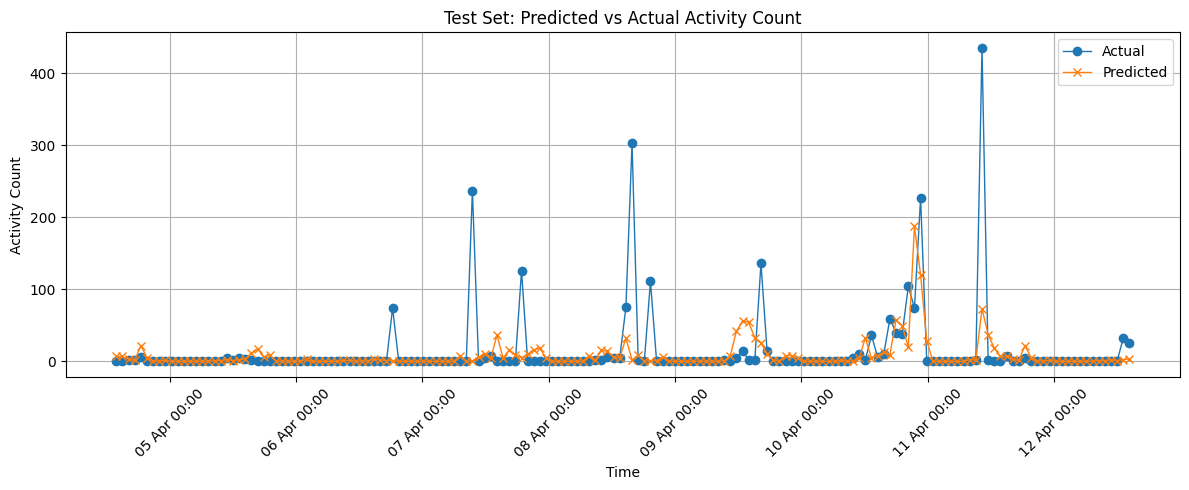

🔵 Actual Peak:    435 at 2025-04-11 10:20:00
🟠 Predicted Peak: 187.52 at 2025-04-10 21:30:00


In [93]:
import matplotlib.dates as mdates

# Ensure timestamps are datetime
timestamps_test = pd.to_datetime(df['timestamp'].iloc[test_inds])

plt.figure(figsize=(12, 5))

plt.plot(timestamps_test, y_test.values, label='Actual', marker='o', linewidth=1)
plt.plot(timestamps_test, y_test_pred, label='Predicted', marker='x', linewidth=1)

# Clean x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))

plt.xlabel("Time")
plt.ylabel("Activity Count")
plt.title("Test Set: Predicted vs Actual Activity Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure timestamps are datetime
timestamps_test = pd.to_datetime(df['timestamp'].iloc[test_inds])

# Build a DataFrame for inspection
test_results = pd.DataFrame({
    'timestamp': timestamps_test,
    'actual_activity_count': y_test.values,
    'predicted_activity_count': y_test_pred
})

# Optionally round predicted values
test_results['predicted_activity_count'] = test_results['predicted_activity_count'].round(2)

# Ensure timestamps are datetime
timestamps_test = pd.to_datetime(df['timestamp'].iloc[test_inds])

# Convert y_test to Series (if needed) for index access
y_test_series = pd.Series(y_test.values, index=timestamps_test)
y_pred_series = pd.Series(y_test_pred, index=timestamps_test)

# Get max values and timestamps
max_actual_val = y_test_series.max()
max_actual_time = y_test_series.idxmax()

max_pred_val = y_pred_series.max()
max_pred_time = y_pred_series.idxmax()

print(f"🔵 Actual Peak:    {max_actual_val} at {max_actual_time}")
print(f"🟠 Predicted Peak: {max_pred_val:.2f} at {max_pred_time}")

#### (Optional) Export Model
The Model can be exported to the current directory

### Interactive Prediction Tool

In [ ]:
date_picker = widgets.DatePicker(description='Select Date')
hour_slider = widgets.IntSlider(min=0, max=23, description='Hour')
minute_slider = widgets.IntSlider(min=0, max=59, step=10, description='Minute')

def forecast_activity(date, hour, minute):
    if date is None:
        print("Select a date.")
        return
    
    ts = pd.Timestamp(datetime.combine(date, datetime.min.time())) + pd.Timedelta(hours=hour, minutes=minute)

    feats = pd.DataFrame([[
        ts.hour,
        ts.minute,
        ts.dayofweek,
        ts.dayofweek >= 5
    ]],
    columns=['hour', 'minute', 'dayofweek', 'weekend'])

    prediction = model.predict(feats)[0]
    print(f"📅 Prediction for {ts.strftime('%Y-%m-%d %H:%M')}: {prediction:.0f} detections")

out = widgets.interactive_output(
    forecast_activity,
    {'date': date_picker, 'hour': hour_slider, 'minute': minute_slider}
)

display(widgets.VBox([date_picker, hour_slider, minute_slider]), out)
